# Test with open source dataset of static hand gestures
Link to download preprocessed hand gestures:

https://www.kaggle.com/ardamavi/sign-language-digits-dataset/download




In [13]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
import pandas as pd
import os

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import scikitplot as skplt
from skimage.io import imread

import warnings
warnings.filterwarnings("ignore")

In [14]:
x = np.load('./dataset/sign-language/X.npy')
y = np.load('./dataset/sign-language/Y.npy')

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')

X shape: (2062, 64, 64)
Y shape: (2062, 10)


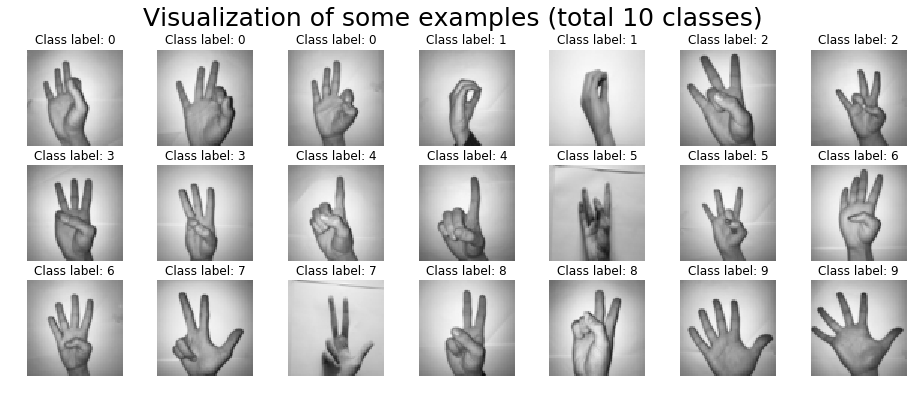

In [15]:
plt.figure(figsize=(16, 6))
figIdx = 1
for i in range(len(x)):
    if i%100==0 and figIdx <= 3*7:
        plt.subplot(3,7,figIdx)
        plt.title(f'Class label: {y[i].argmax()}')
        plt.imshow(cv2.cvtColor(x[i], cv2.COLOR_BGR2RGB))
        plt.axis('off')
        figIdx+=1
plt.suptitle(f'Visualization of some examples (total {y.shape[1]} classes)', fontsize=25)
plt.show()

In [16]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 42)
xTrain = xTrain.reshape(-1, 64, 64, 1)
xTest = xTest.reshape(-1, 64, 64, 1)

In [24]:
class CNN:
    def build(numClasses, channels):
        cnn = Sequential()
        cnn.add(Conv2D(filters=16,kernel_size=(5,5),activation="relu",padding="same",input_shape=(64,64,channels)))
        cnn.add(Conv2D(filters=32,kernel_size=(5,5),activation="relu",padding="same"))
        cnn.add(BatchNormalization(axis=-1, epsilon=2e-5, momentum=0.9))
        cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))

        cnn.add(Conv2D(filters=32,kernel_size=(4,4),activation="relu",padding="same", kernel_regularizer = l2(0.001)))
        cnn.add(Conv2D(filters=32,kernel_size=(4,4),activation="relu",padding="same", kernel_regularizer = l2(0.001)))
        cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"))
        cnn.add(BatchNormalization(axis=-1, epsilon=2e-5, momentum=0.8))
        cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))
        cnn.add(Dropout(0.5))
        
        cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same", kernel_regularizer = l2(0.001)))
        cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",padding="same", kernel_regularizer = l2(0.001)))
        cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu",padding="same", kernel_regularizer = l2(0.001)))
        cnn.add(BatchNormalization(axis=-1, epsilon=2e-5, momentum=0.8))
        cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))
        cnn.add(Dropout(0.5))

        cnn.add(Flatten())
        
        cnn.add(Dropout(0.5))
        cnn.add(Dense(256, activation='relu'))
        
        cnn.add(Dense(numClasses, activation='softmax'))

        cnn.summary()

        cnn.compile(optimizer=Adam(lr=0.0005, decay = 1e-7), 
                    loss = keras.losses.categorical_crossentropy, 
                    metrics = ['accuracy'])

        return cnn

In [25]:
#modelsmall = CNN.build(10)

model = CNN.build(10, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 64, 64, 16)        416       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 64, 64, 32)        12832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 64)        18496     
__________

In [26]:
batch_size = 32
epochs = 50
steps_per_epoch = batch_size // xTrain.shape[0]


history = model.fit(xTrain, yTrain, epochs=epochs,
                    validation_data=(xTest, yTest))

Train on 1649 samples, validate on 413 samples
Epoch 1/50
1649/1649 [==============================] - 32s 19ms/step - loss: 3.2778 - acc: 0.2953 - val_loss: 1.4803 - val_acc: 0.6513
Epoch 2/50
1649/1649 [==============================] - 28s 17ms/step - loss: 1.4106 - acc: 0.6240 - val_loss: 0.8996 - val_acc: 0.7869
Epoch 3/50
1649/1649 [==============================] - 30s 18ms/step - loss: 1.0670 - acc: 0.7538 - val_loss: 0.7529 - val_acc: 0.8523
Epoch 4/50
1649/1649 [==============================] - 30s 18ms/step - loss: 0.9269 - acc: 0.8181 - val_loss: 0.8782 - val_acc: 0.8087
Epoch 5/50
1649/1649 [==============================] - 31s 19ms/step - loss: 0.8131 - acc: 0.8381 - val_loss: 0.6313 - val_acc: 0.9080
Epoch 6/50
1649/1649 [==============================] - 31s 19ms/step - loss: 0.7735 - acc: 0.8642 - val_loss: 0.6942 - val_acc: 0.8789
Epoch 7/50
1649/1649 [==============================] - 30s 18ms/step - loss: 0.7373 - acc: 0.8636 - val_loss: 0.5615 - val_acc: 0.9249
E

In [30]:
model.save_weights('./weights/cnn_1.h5')

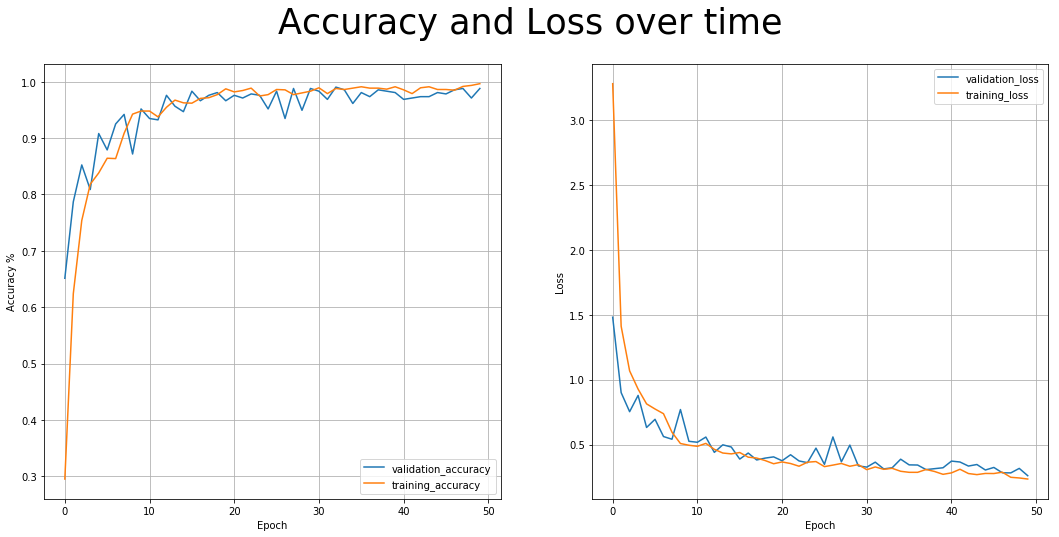

In [27]:
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.plot(history.history["acc"],label="training_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss")
plt.plot(history.history["loss"],label="training_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("Accuracy and Loss over time",fontsize=35)

plt.show()


In [28]:
pred = model.predict(xTest)
predLabels = np.argmax(pred, axis = 1)
yLabels = np.argmax(yTest, axis=1)

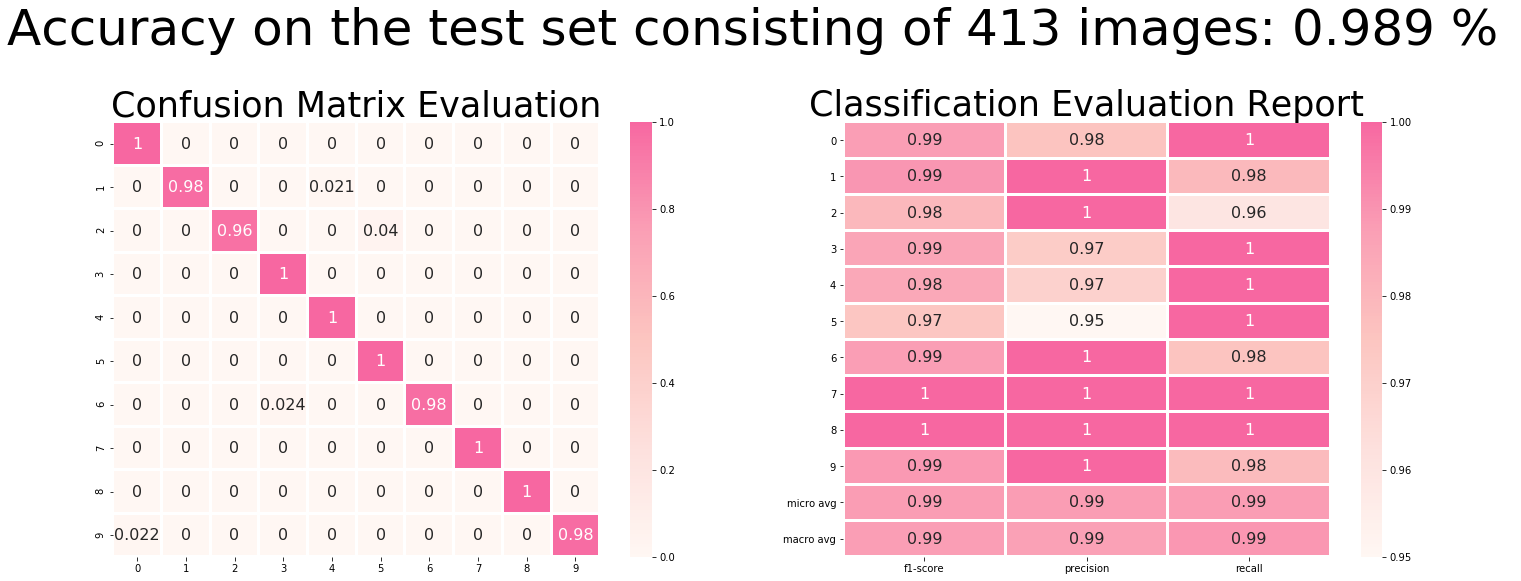

<Figure size 432x288 with 0 Axes>

In [29]:
cm = confusion_matrix(yLabels, predLabels)
cmNorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmNorm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

target_names = list("0123456789")
labels = np.arange(10)
clf_report = classification_report(yLabels,
                                   predLabels,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)
accList = []
for i in range(len(cmNorm)):
    accList.append(cmNorm[i][i])

plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
sns.heatmap(df_cm, annot=True, cmap="RdPu", 
                center=True, linewidths=2,annot_kws={'size':16})
plt.title('Confusion Matrix Evaluation', fontsize=35)


plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-1].T, 
            annot=True,cmap="RdPu", center=True, linewidths=2,annot_kws={'size':16})
plt.title('Classification Evaluation Report', fontsize = 35)
plt.suptitle('Accuracy on the test set consisting of {} images: {:.3f} % \n'.format(len(yTest), np.mean(accList)), fontsize = 50, y=1.08)

plt.show()
plt.savefig('./Evaluation/vgg.png')